<a href="https://colab.research.google.com/github/RubeRad/tcscs/blob/master/StyleGAN3inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@markdown #**Setup libraries and functions** 🏗️🛠️

!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
!git clone https://github.com/NVlabs/stylegan3
!pip install einops ninja
!pip install wget

import sys
sys.path.append('./stylegan3')

import io
import os, time
import pickle
import shutil
import numpy as np
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import copy
import imageio
import unicodedata
import re
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
from time import perf_counter
from stylegan3.dnnlib.util import open_url
import wget


device = torch.device('cuda:0')

# Load VGG16 feature detector.
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)
print('Using device:', device, file=sys.stderr)

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path:
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename

def download_img(img_url):
    try:
        return wget.download(img_url,out="input.jpg")
    except:
        return

# Projector

def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = -1,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):

    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    if w_avg_samples > 0:
      logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
      z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    else:
      seed = np.random.randint(0, 2**32 - 1)
      z_samples = np.random.RandomState(seed).randn(1, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])

def get_perceptual_loss(synth_image, target_features):
    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_image = (synth_image + 1) * (255/2)
    if synth_image.shape[2] > 256:
        synth_image = F.interpolate(synth_image, size=(256, 256), mode='area')

    # Features for synth images.
    synth_features = vgg16(synth_image, resize_images=False, return_lpips=True)
    return (target_features - synth_features).square().sum()

def get_target_features(target):
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    return vgg16(target_images, resize_images=False, return_lpips=True)

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

In [36]:
def get_perceptual_loss(synth_image, target_features):
    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_image = (synth_image + 1) * (255/2)
    if synth_image.shape[2] > 256:
        synth_image = F.interpolate(synth_image, size=(256, 256), mode='area')

    # Features for synth images.
    synth_features = vgg16(synth_image, resize_images=False, return_lpips=True)
    return (target_features - synth_features).square().sum()

In [45]:
import matplotlib.pyplot as plt
import glob
from os.path import dirname, basename, splitext, join, exists
import pickle

In [ ]:
#@markdown #**Model selection** 🎭


#@markdown There are 4 pre-trained options to play with:
#@markdown - FFHQ: Trained with human faces.
#@markdown - MetFaces: Trained with paintings/portraits of human faces.
#@markdown - AFHQv2: Trained with animal faces.
#@markdown - Cosplay: Trained by [l4rz](https://twitter.com/l4rz) with cosplayer's faces.
#@markdown - Wikiart: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the Wikiart 1024 dataset.
#@markdown - Landscapes: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the LHQ dataset.


#@markdown **Run this cell again if you change the model**.

#@markdown ---

base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"

Model = 'FFHQ' #@param ["FFHQ", "MetFaces", "AFHQv2", "cosplay", "Wikiart", "Landscapes"]

#@markdown ---

model_name = {
    "FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl",
    "MetFaces": base_url + "stylegan3-r-metfacesu-1024x1024.pkl",
    "AFHQv2": base_url + "stylegan3-t-afhqv2-512x512.pkl",
    "cosplay": "https://l4rz.net/cosplayface-snapshot-stylegan3t-008000.pkl",
    "Wikiart": "https://archive.org/download/wikiart-1024-stylegan3-t-17.2Mimg/wikiart-1024-stylegan3-t-17.2Mimg.pkl",
    "Landscapes": "https://archive.org/download/lhq-256-stylegan3-t-25Mimg/lhq-256-stylegan3-t-25Mimg.pkl"
}

network_url = model_name[Model]

with open(fetch_model(network_url), 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

In [53]:
!rm /content/stylegan3/outputs/*/*.png

In [56]:
seed = 1234
steps = 2000
update = 100
random_starters = 50
inputs = glob.glob('/content/stylegan3/inputs/*.png')
inputs = sorted(inputs)
inputs

['/content/stylegan3/inputs/AG.png',
 '/content/stylegan3/inputs/AL.png',
 '/content/stylegan3/inputs/EE.png',
 '/content/stylegan3/inputs/JJ.png',
 '/content/stylegan3/inputs/JS.png',
 '/content/stylegan3/inputs/JW.png',
 '/content/stylegan3/inputs/KT.png',
 '/content/stylegan3/inputs/MS.png',
 '/content/stylegan3/inputs/NL.png',
 '/content/stylegan3/inputs/RL.png',
 '/content/stylegan3/inputs/RS.png',
 '/content/stylegan3/inputs/SJ.png']

WORKING ON /content/stylegan3/inputs/AG.png
chosen starter AG/random02.png


  0%|          | 0/2000 [00:00<?, ?it/s]

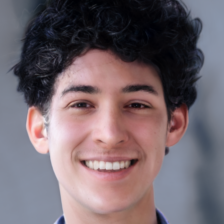

image 99/2000 | loss: 0.3022172451019287


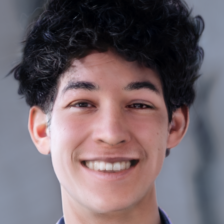

image 199/2000 | loss: 0.28715357184410095


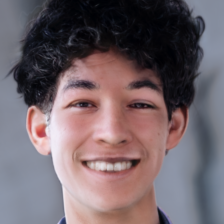

image 299/2000 | loss: 0.24500301480293274


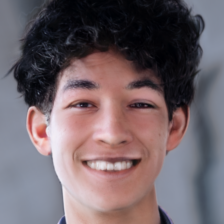

image 399/2000 | loss: 0.22768297791481018


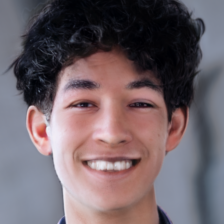

image 499/2000 | loss: 0.2354254573583603


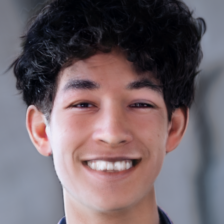

image 599/2000 | loss: 0.2106301337480545


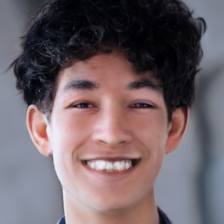

image 699/2000 | loss: 0.2219322770833969


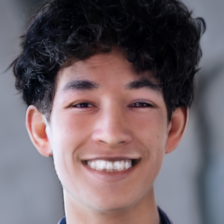

image 799/2000 | loss: 0.20636498928070068


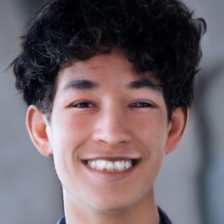

image 899/2000 | loss: 0.1988636553287506


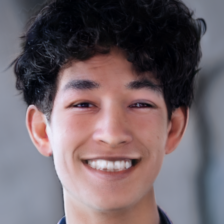

image 999/2000 | loss: 0.20836979150772095


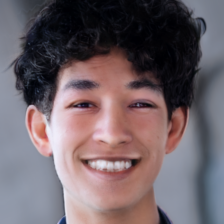

image 1099/2000 | loss: 0.18607866764068604


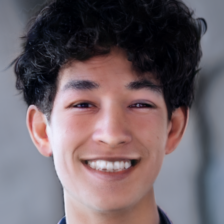

image 1199/2000 | loss: 0.19948889315128326


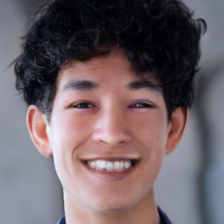

image 1299/2000 | loss: 0.16996628046035767


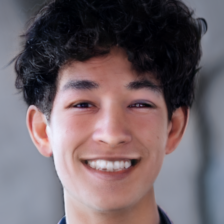

image 1399/2000 | loss: 0.183430016040802


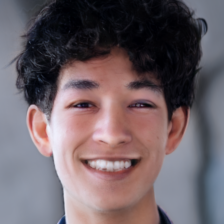

image 1499/2000 | loss: 0.1821345090866089


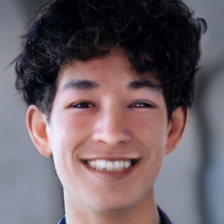

image 1599/2000 | loss: 0.19981321692466736


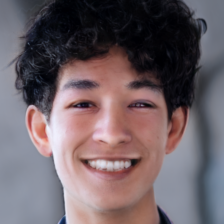

image 1699/2000 | loss: 0.188111811876297


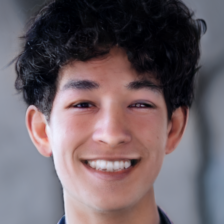

image 1799/2000 | loss: 0.1736658215522766


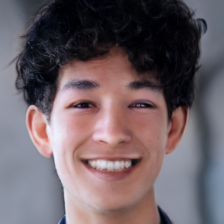

image 1899/2000 | loss: 0.18044650554656982


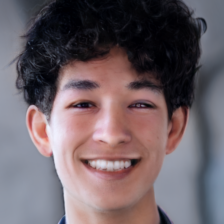

image 1999/2000 | loss: 0.1708887666463852
Saving W vector to /content/stylegan3/outputs/w_AG.npy
WORKING ON /content/stylegan3/inputs/AL.png
chosen starter AL/random32.png


  0%|          | 0/2000 [00:00<?, ?it/s]

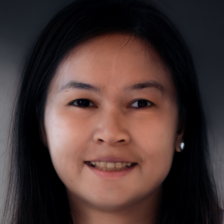

image 99/2000 | loss: 0.23120565712451935


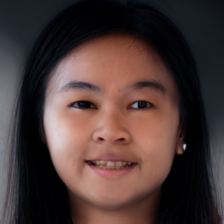

image 199/2000 | loss: 0.24043063819408417


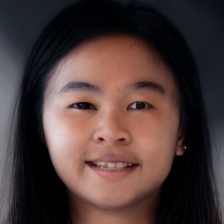

image 299/2000 | loss: 0.21086633205413818


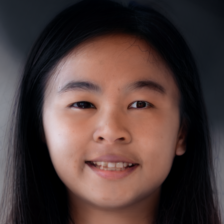

image 399/2000 | loss: 0.18305560946464539


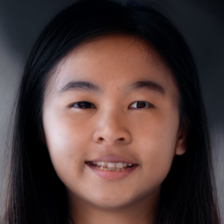

image 499/2000 | loss: 0.17839249968528748


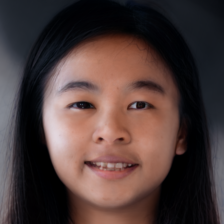

image 599/2000 | loss: 0.17125092446804047


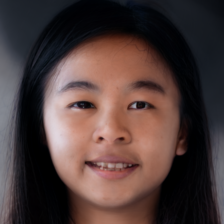

image 699/2000 | loss: 0.18488341569900513


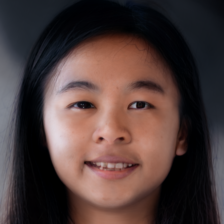

image 799/2000 | loss: 0.16225817799568176


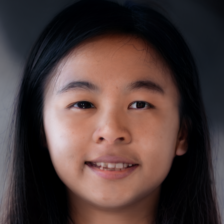

image 899/2000 | loss: 0.1586226522922516


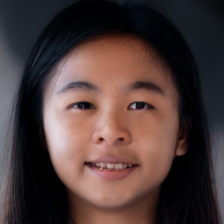

image 999/2000 | loss: 0.15787431597709656


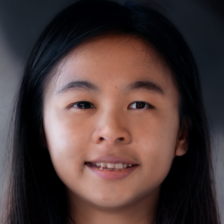

image 1099/2000 | loss: 0.15873098373413086


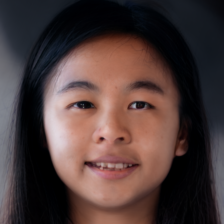

image 1199/2000 | loss: 0.15626674890518188


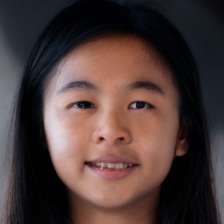

image 1299/2000 | loss: 0.15999385714530945


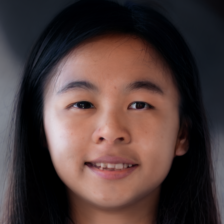

image 1399/2000 | loss: 0.15595419704914093


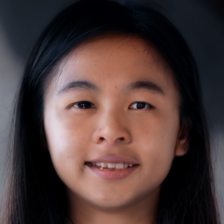

image 1499/2000 | loss: 0.13235126435756683


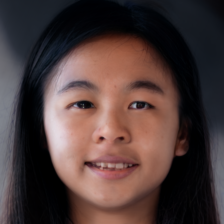

image 1599/2000 | loss: 0.14223454892635345


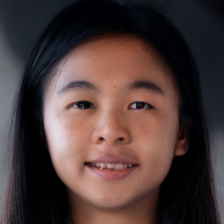

image 1699/2000 | loss: 0.1471930742263794


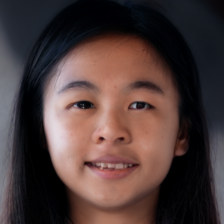

image 1799/2000 | loss: 0.13634216785430908


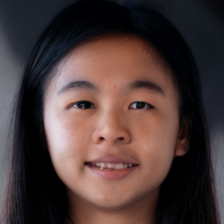

image 1899/2000 | loss: 0.15197338163852692


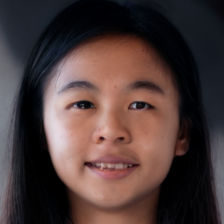

image 1999/2000 | loss: 0.14178566634655
Saving W vector to /content/stylegan3/outputs/w_AL.npy
WORKING ON /content/stylegan3/inputs/EE.png
chosen starter EE/random34.png


  0%|          | 0/2000 [00:00<?, ?it/s]

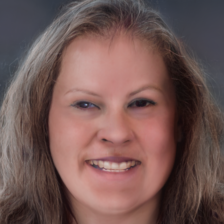

image 99/2000 | loss: 0.4089733362197876


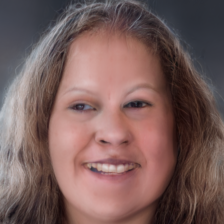

image 199/2000 | loss: 0.32979413866996765


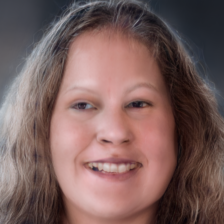

image 299/2000 | loss: 0.271007776260376


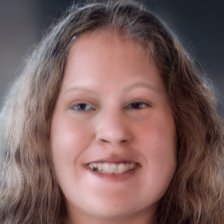

image 399/2000 | loss: 0.32256966829299927


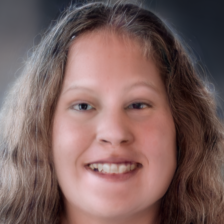

image 499/2000 | loss: 0.2322154939174652


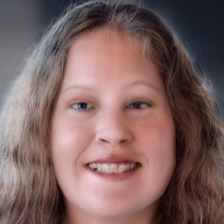

image 599/2000 | loss: 0.24341313540935516


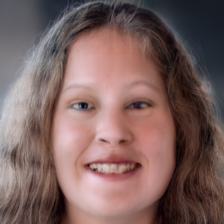

image 699/2000 | loss: 0.23633328080177307


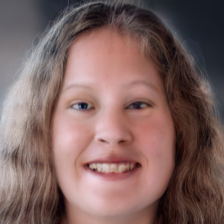

image 799/2000 | loss: 0.2215641736984253


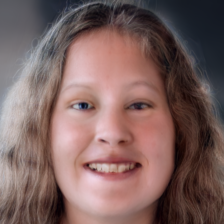

image 899/2000 | loss: 0.22533535957336426


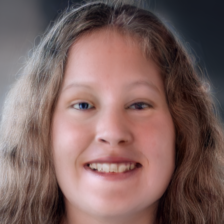

image 999/2000 | loss: 0.23236094415187836


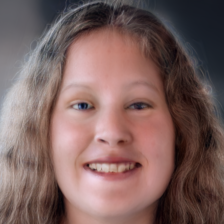

image 1099/2000 | loss: 0.24087974429130554


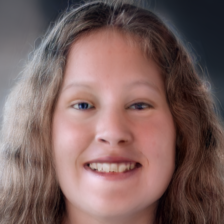

image 1199/2000 | loss: 0.2199546992778778


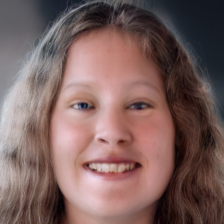

image 1299/2000 | loss: 0.21397554874420166


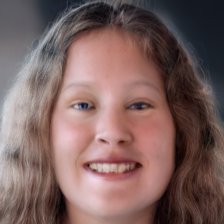

image 1399/2000 | loss: 0.22564533352851868


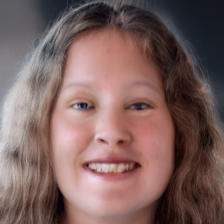

image 1499/2000 | loss: 0.19108173251152039


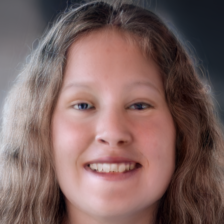

image 1599/2000 | loss: 0.23468399047851562


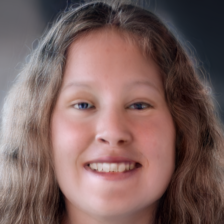

image 1699/2000 | loss: 0.19344767928123474


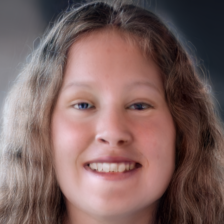

image 1799/2000 | loss: 0.18471935391426086


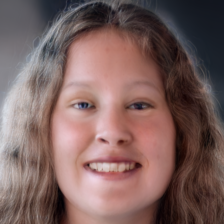

image 1899/2000 | loss: 0.24066820740699768


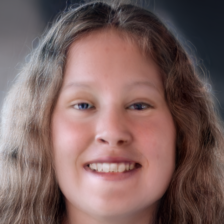

image 1999/2000 | loss: 0.1972126066684723
Saving W vector to /content/stylegan3/outputs/w_EE.npy
WORKING ON /content/stylegan3/inputs/JJ.png
chosen starter JJ/random41.png


  0%|          | 0/2000 [00:00<?, ?it/s]

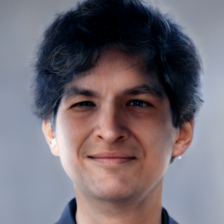

image 99/2000 | loss: 0.37234753370285034


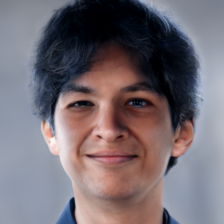

image 199/2000 | loss: 0.2716309726238251


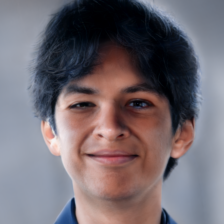

image 299/2000 | loss: 0.2530781328678131


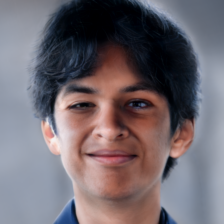

image 399/2000 | loss: 0.21549251675605774


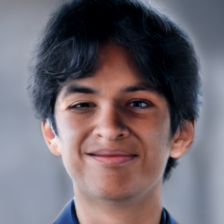

image 499/2000 | loss: 0.2059757113456726


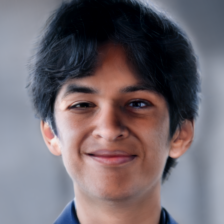

image 599/2000 | loss: 0.19720104336738586


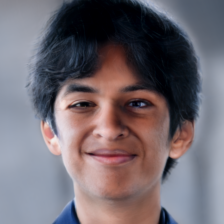

image 699/2000 | loss: 0.19321149587631226


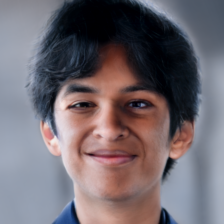

image 799/2000 | loss: 0.20142918825149536


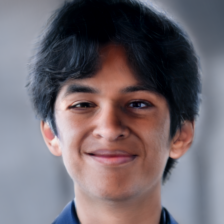

image 899/2000 | loss: 0.18151889741420746


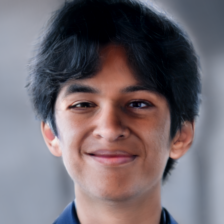

image 999/2000 | loss: 0.17621952295303345


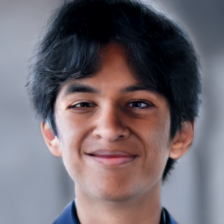

image 1099/2000 | loss: 0.17087671160697937


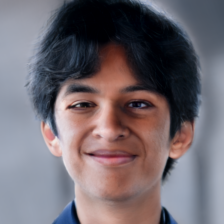

image 1199/2000 | loss: 0.18015381693840027


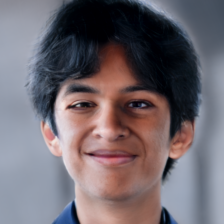

image 1299/2000 | loss: 0.18248064815998077


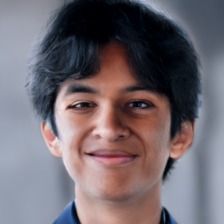

image 1399/2000 | loss: 0.16915297508239746


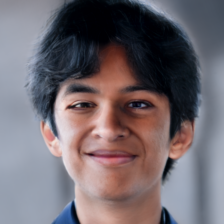

image 1499/2000 | loss: 0.16517296433448792


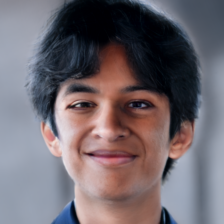

image 1599/2000 | loss: 0.17056429386138916


In [ ]:
torch.manual_seed(seed)

for target_image_filename in inputs:
    print('WORKING ON',target_image_filename)
    target_pil = Image.open(target_image_filename).convert('RGB')
    w,h = target_pil.size
    s = min(w,h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    target_tensor = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)

    tf = Compose([Resize(224),
            lambda x: torch.clamp((x+1)/2,min=0,max=1),])

    LL = splitext(basename(target_image_filename))[0]
    outdir = join('/content/stylegan3/outputs', LL)
    if not exists(outdir):
        os.mkdir(outdir)

    projection_target = target_tensor
    target_features = get_target_features(projection_target)

    # search a bunch of random images for a decent starter
    with torch.no_grad():
        qs = []
        losses = []

        for randomno in range(random_starters):
            q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
            images = G.synthesis(q * w_stds + G.mapping.w_avg)
            loss = get_perceptual_loss(images, target_features)
            i = torch.argmin(loss)
            qs.append(q[i])
            losses.append(loss)
            pil_image = TF.to_pil_image(images[0].add(1).div(2).clamp(0,1))
            fname = join(outdir, 'random{:02d}.png'.format(randomno))
            pil_image.save(fname)
        qs = torch.stack(qs)
        losses = torch.stack(losses)
        i = torch.argmin(losses)
        q = qs[i].unsqueeze(0).requires_grad_()
        print('chosen starter {}/random{:02d}.png'.format(LL, i))

    # Sampling loop
    q_ema = q
    best_w = None
    opt = torch.optim.AdamW([q], lr=0.03, betas=(0.0,0.999))
    loop = tqdm(range(steps))
    for i in loop:
        opt.zero_grad()
        w = q * w_stds
        image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
        loss = get_perceptual_loss(image, target_features)
        loss.backward()
        opt.step()
        loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

        q_ema = q_ema * 0.9 + q * 0.1
        best_w = q_ema * w_stds + G.mapping.w_avg
        image = G.synthesis(best_w, noise_mode='const')

        if i % update == update-1:
            display(TF.to_pil_image(tf(image)[0]))
            print(f"image {i}/{steps} | loss: {loss}")
        pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
        fname = join(outdir, 'iteration{:04}.png'.format(i))
        pil_image.save(fname)

    # save W vector
    fname = join(dirname(outdir), 'w_{}.npy'.format(LL))
    print('Saving W vector to',fname)
    with open(fname, 'wb') as binary_file:
        pickle.dump(best_w, binary_file)


In [ ]:
#@markdown #**Parameters** ✍️
#@markdown ---
#@markdown `target_image_filename`: URL or an uploaded file

target_image_filename = "stylegan3/SJ.png"#@param {type:"string"}
steps = 50#@param {type:"number"}

if target_image_filename.lower().startswith("http"):
  target_image_filename = download_img(target_image_filename)
target_pil = Image.open(target_image_filename).convert('RGB')
w, h = target_pil.size
s = min(w, h)
target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
target_pil = target_pil.resize((G.img_resolution, G.img_resolution), Image.LANCZOS)
target_uint8 = np.array(target_pil, dtype=np.uint8)
target_tensor = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)



  0%|          | 0/50 [00:00<?, ?it/s]

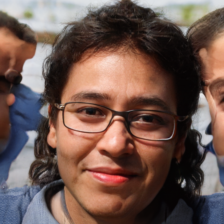

image 0/50 | loss: 0.6789767742156982


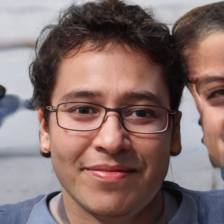

image 10/50 | loss: 0.476884126663208


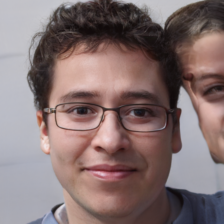

image 20/50 | loss: 0.4798421859741211


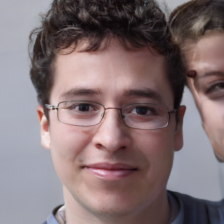

image 30/50 | loss: 0.41756996512413025


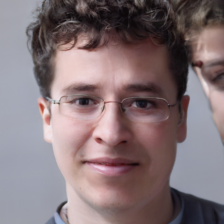

image 40/50 | loss: 0.42616456747055054


In [ ]:
#@markdown #**Run the inversion** 🚀

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

seed = 14

best_w = None
timestring = time.strftime('%Y%m%d%H%M%S')
projection_target = target_tensor
#def run(timestring, projection_target):
if True:
  torch.manual_seed(seed)

  target_features = get_target_features(projection_target)



  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(8):
      q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
      images = G.synthesis(q * w_stds + G.mapping.w_avg)
      loss = get_perceptual_loss(images, target_features)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss)
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()

  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0.0,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    loss = get_perceptual_loss(image, target_features)
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    best_w = q_ema * w_stds + G.mapping.w_avg
    image = G.synthesis(best_w, noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"image {i}/{steps} | loss: {loss}")
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')



In [ ]:
best_w

tensor([[[-0.0705, -0.0193,  1.3586,  ..., -0.2725,  0.1046,  1.4516],
         [-0.1501, -0.2725,  1.3171,  ..., -0.1745,  0.1977,  1.5237],
         [-0.3395, -0.1928,  1.2120,  ..., -0.1710, -0.0462,  1.6039],
         ...,
         [ 0.0360,  0.2136,  1.1579,  ..., -0.1401,  0.5545,  1.4723],
         [ 0.1273, -0.0392,  0.9198,  ..., -0.1020,  0.2745,  1.3760],
         [ 0.2249,  0.1005,  1.0993,  ..., -0.3615,  0.4304,  1.3296]]],
       device='cuda:0', grad_fn=<AddBackward0>)

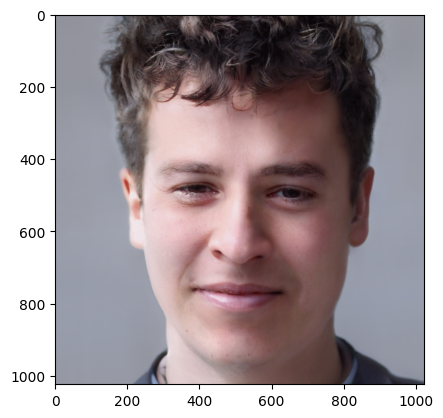

In [ ]:
image = G.synthesis(best_w, noise_mode='const')
pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
plt.imshow(pil_image)

In [ ]:
#@markdown #**Generate video** 🎥

#@markdown You can edit frame rate and stuff by double-clicking this tab.

frames = os.listdir(f"samples/{timestring}")
frames = len(list(filter(lambda filename: filename.endswith(".jpg"), frames))) #Get number of jpg generated

init_frame = 1 #This is the frame where the video will start
last_frame = frames #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 60

total_frames = last_frame-init_frame

#Desired video time in seconds
video_length = 14 #@param {type:"number"}
#Video filename
video_name = "testvid" #@param {type:"string"}
video_name = slugify(video_name)

if not video_name:
  video_name = "video"
# frames = []
# tqdm.write('Generating video...')
# for i in range(init_frame,last_frame): #
#     filename = f"samples/{timestring}/{i:04}.jpg"
#     frames.append(Image.open(filename))

fps = np.clip(total_frames/video_length,min_fps,max_fps)

print("Generating video...")
!ffmpeg -r {fps} -i samples/{timestring}/%04d.jpg -c:v libx264 -vf fps={fps} -pix_fmt yuv420p samples/{video_name}.mp4 -frames:v {total_frames}

# from subprocess import Popen, PIPE
# p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', f'samples/{video_name}.mp4'], stdin=PIPE)
# for im in tqdm(frames):
#     im.save(p.stdin, 'PNG')
# p.stdin.close()

print("The video is ready")

Generating video...
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --

In [ ]:
#@markdown #**Download video** 📀

#Video filename

files.download(f"samples/{video_name}.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
w_stds

tensor([[0.8456, 0.8542, 0.8235,  ..., 0.7596, 0.9873, 0.4751],
        [0.8456, 0.8542, 0.8235,  ..., 0.7596, 0.9873, 0.4751],
        [0.8456, 0.8542, 0.8235,  ..., 0.7596, 0.9873, 0.4751],
        ...,
        [0.8456, 0.8542, 0.8235,  ..., 0.7596, 0.9873, 0.4751],
        [0.8456, 0.8542, 0.8235,  ..., 0.7596, 0.9873, 0.4751],
        [0.8456, 0.8542, 0.8235,  ..., 0.7596, 0.9873, 0.4751]],
       device='cuda:0')

In [ ]:
best_w

NameError: name 'best_w' is not defined

AttributeError: 'NoneType' object has no attribute 'ndim'